In [9]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns
%matplotlib inline

In [10]:
df = pd.read_csv('pared_turnstile.csv', low_memory=False)

In [11]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']
df.set_index('DATETIME', inplace=True)
df.drop(['Unnamed: 0','ENTRY_DIFFS','EXIT_DIFFS','ENTRIES','EXITS','zipcode','hir'], axis=1, inplace=True)

In [12]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday
df2['DATE'] = df2['DATETIME'].dt.date
df2['TIME'] = df2['DATETIME'].dt.time

### Heatmap: volume of traffic by day of week & time of day, for a given station

In [13]:
def hm_data_dow_time(s, data_col, dow):
    '''Generates heatmap data for day-of-week x time-of-day.
    Inputs: s (string) = station name. 
            data_col (string)  = data column in df2 (e.g. 'ENTRY_DIFFS')
            dow (integer) = day of week, an integer from 0-6, with 0 being Monday
    Output: List of lists of data_col summed over day of week and station, grouped by time
    '''
    assert dow in range(7), "dow must be an integer between 0-6"
    
    return df2[(df2['DAY_OF_WEEK'] == dow) & (df2['STATION'] == s)].groupby('TIME')[data_col].median()

## Plotting the final stations

In [14]:
final_data = pd.read_csv('filtered.csv')
final_station_list = final_data['STATION'].values

In [17]:
def heatmap_grid_1x5(station_list, fig_title, filename='temp'):
    '''Inputs: station_list (list) = list of station names
               fig_title (string) = Figure Title
                filename (string) = filename, with extension, if desired to save figure
        Output:
            1x5 grid of heatmaps, plotting total volume (entries + exits) by day of week & time of day
    '''
    
    vmax = df2['TOTAL'].max() * 1.5
    vmin = df2['TOTAL'].min()
    
    xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
    ylabel_hm = [x[:3] for x in calendar.day_name]
    
    fig, ax = plt.subplots(1,5, figsize=(20,4))
    plt.suptitle(fig_title, fontsize=20)

    for i, s in enumerate(station_list):
        ax = plt.subplot(1,5,i+1)

        if i == 0:
            ylabel=ylabel_hm
            cbar=False
        elif i == 4:
            ylabel=False
            cbar=True
        else:
            ylabel=False
            cbar=False

        xlabel=xlabel_hm

        hm_data = [hm_data_dow_time(s, 'TOTAL', d) for d in range(7)]
        sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                    cbar=cbar, cmap='coolwarm')
        
        cbar_ax = None
        ax.tick_params(labelsize=14)
        ax.tick_params(axis='y',labelrotation=0)
        plt.title(s, fontsize=16)
    
    if filename != 'temp':
        plt.savefig(filename, dpi=180, transparent=True)

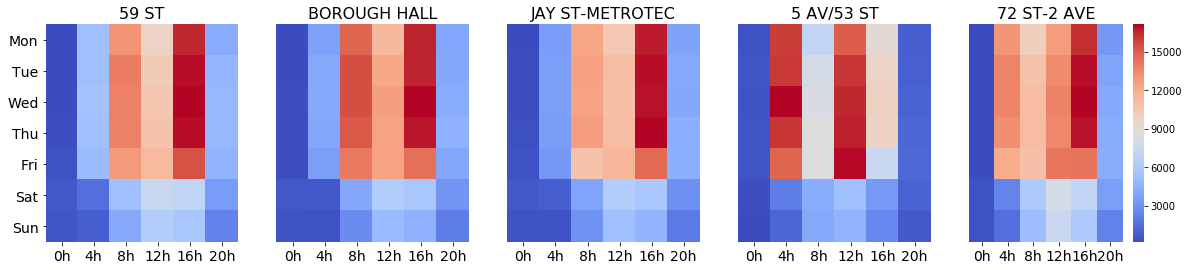

In [18]:
heatmap_grid_1x5(final_station_list, '', 'final_station_heatmaps.png')

If you want to plot it such that the legend (cbar) doesn't "squish" the 5th plot:

https://stackoverflow.com/questions/42712304/seaborn-heatmap-subplots-keep-axis-ratio-consistent?rq=1
